# Домашнее задание 1

NB! Важный дисклеймер, который нужно учитывать во всех домашних заданиях по курсу. Обосновывайте ваши действия. При проверке нам важно увидеть, что вы комплексно подходите к задаче и понимаете, зачем нужны те или иные шаги. Примеры важных моментов:

* Я использую следующие предпосылки: ...
* Я использую признак X, потому что ...
* Я выбираю модель Y с такими-то параметрами, потому что ...
* Я использую для входных данных такое-то преобразование, потому что характеристики ряда XXX, а я хочу добиться YYY.
* Я использую периоды сезонности X и Y, потому что вижу на графиках ...
* ...

Необоснованные дейтвия могут остаться без оценки.

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и ML-моделями.

Мы сотрудники одного из крупных банков с развитой сетью банкоматов. Предположим, что мы рассматриваем банкоматы, которые работают только на выдачу наличных. Возможно на текущий момент это редкость, но для периода, когда собирался датасет, они были распространены.

Наша задача состоит в том, чтобы предсказать спрос на наличность и вовремя загрузить в банкомат деньги, чтобы он работал бесперебойно. В то же время, мы хотим не гонять доблестных инкассаторов к наполовину полным банкоматам, так как их перемещения стоят денег. Попытаемся построить модель, которая для конкретного банкомата будет прогнозировать количество денег, которые будет необходимо выдать в следующие периоды.

Конечно, в оригинале задача была сложнее, так как банкоматы могут ломаться и простаивать, о чём вендору известно. Ещё, например, некоторые банкоматы доступны 24 часа в сутки, а некоторые -- наоборот, стоят в закрываемых помещениях. Но мы на такой уровень погружаться не будем.

В файле `data.csv` представлены три временных ряда. Каждый из них представляет собой объём выданной наличности в определённом банкомате.

В файле `description.csv` представлено краткое описание каждого банкомата: ID, Адрес, описание местоположения, а также географические координаты.

Каждый из вас будет использовать только один ряд. Жеребьёвка будет проводится с помощью сложнейшего стохастического алгоритма в ячейке ниже.

In [276]:
full_name = "Сюй Алиса" #Введите ваше ФИО

print(f"ID вашего временного ряда: {len(full_name)%3}")

ID вашего временного ряда: 0


Банкомат под номером 0	- ул Моховая, 9	Факультет журналистики МГУ им.М.В.Ломоносова

## 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты к Timestamp. Определите частоту данных.

* Если необходимо, исходя из частоты выберите [оффсет](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) и ресэмплируйте к нему.
* Если необходимо, заполните пропуски
* Если необходимо, сделайте иные преобразования ряда

In [277]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (15,8)

In [278]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv('https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/refs/heads/master/2025-spring/homeworks/hw1/data.csv')
data.Date = pd.to_datetime(data.Date) # меняем тип
data.set_index("Date", inplace=True)
data.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2017-09-08', '2017-09-09', '2017-09-10', '2017-09-11',
               '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
               '2017-09-16', '2017-09-17'],
              dtype='datetime64[ns]', name='Date', length=991, freq=None)

In [279]:
print(f'Частота исходных данных - {pd.infer_freq(data.index)}')

Частота исходных данных - D


In [280]:
# пропусков нет по всем колонкам
data.isnull().any()

,0
1,False
0,False
2,False


Посмотрим, за какие дни выдача в банкомате была нулевая

In [281]:
data[data['0'] == 0].index.day_name().value_counts()

,count
Date,
Sunday,89
Monday,16
Saturday,15
Friday,9
Tuesday,5
Wednesday,5
Thursday,4


Банкомат чаще всего не работал в воскресенье, а наименьшее количество сбоев зафиксировано в будние дни, особенно во вторник, среду и четверг. Это может быть связано с особым графиком работы университета, например воскресенье - выходной день, по выходным дням в связи с пониженной нагрузкой могут проводиться технические работы - сюда подпадают суббота и понедельник, а также, иногда праздничные дни переподают/растягиваются на соседние будние дни.

Возможно студенты журфака мгу просто не учатся по субботам-понедельникам, поэтому спрос на деньги крайне низок в эти дни. Либо охранник закрывает банкомат на замок.

Посмотрим на кусочек дневного графика:

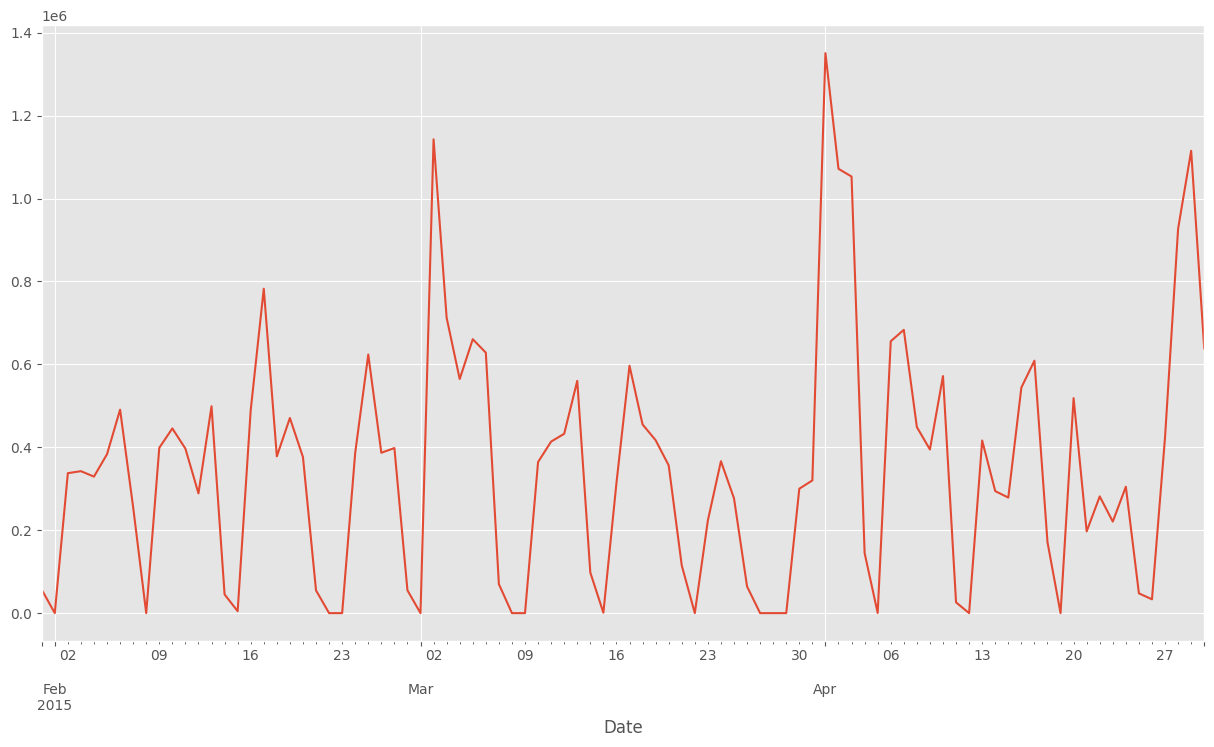

In [282]:
data['0'][30:120].plot();

По рисунку видно недельную сезонность, количество выданных денег максимально в середине недели, а к концу сходится до нуля.

Если понижаем частоту данных до месяца, то возможно получится легче разглядеть паттерны в динамике выданных банкоматом денег.

Пика достигаем примерно в декабре, далее объем падает и начинает отрастать только после января (где-то в первом квартале), во втором квратале начинается падение, минимума достигаем где-то в августе/сентябре. После летнего минимума начинается восстановление спроса - корректируемся и снова выходим на пиковые значения к концу года. Спрос на деньги растет ближе к новогодним праздникам.

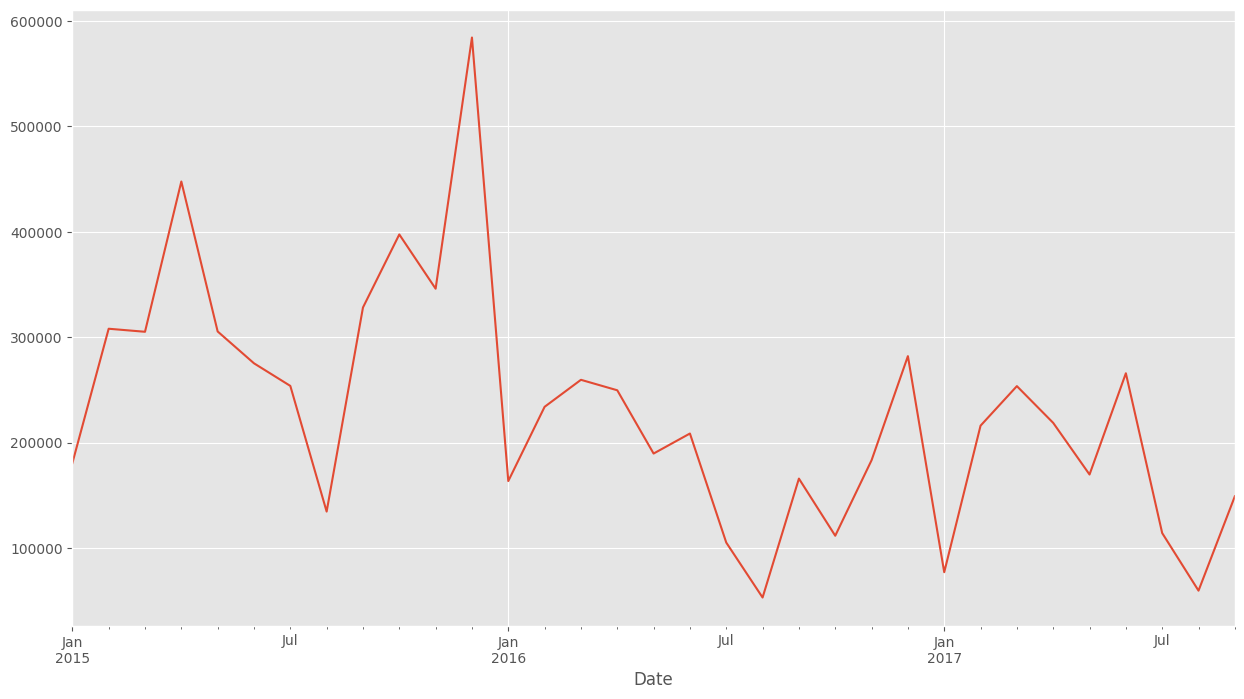

In [283]:
data.resample(pd.offsets.MonthEnd()).mean()['0'].plot();

## 2) Эксплоративный анализ (0.75 балла)

#### 2.1) Визуальный анализ (0.5 балла)

Изобразите временной ряд и его автокорреляции до порядка, который сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Как эти особенности могут помочь прогнозировать?  Ответьте на **каждый** вопрос. Можете дополнительно построить

`Hint`: Для трендированных рядов: если построить коррелограммы на приращениях ряда, а не на исходных величинах, то некоторые паттерны видны лучше.


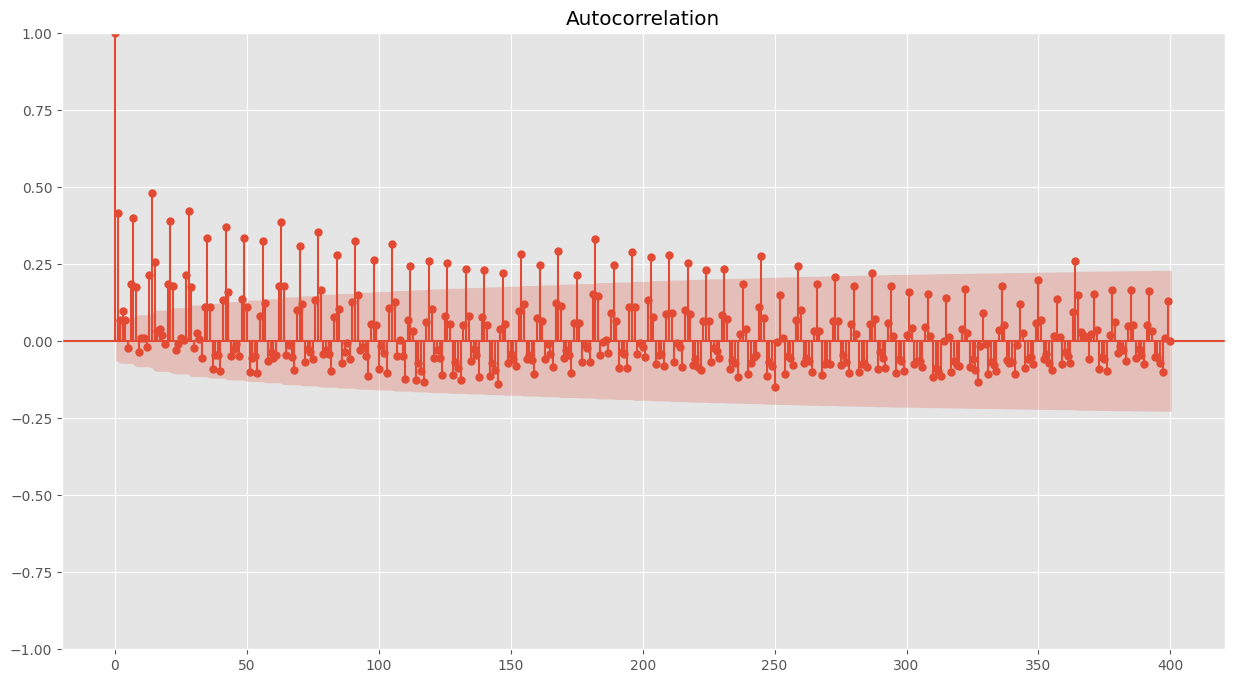

In [284]:
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['0'], lags = 400); #автокорреляция на исходных данных

Есть регулярные выбросы на определённых лагах (y_t-7, y_t-14, y_t-21), это может указывать на достаточно выраженную недельную сезонность. Столбики - значения автокорреляции при разных лагах, выходят за область дов интервала - сезонная автокорреляция значима, из несезонных - значимы y_t-1, y_t-6. Так же значим лаг 365. Автокорреляция постепенно уменьшается, но не обнуляется быстро.

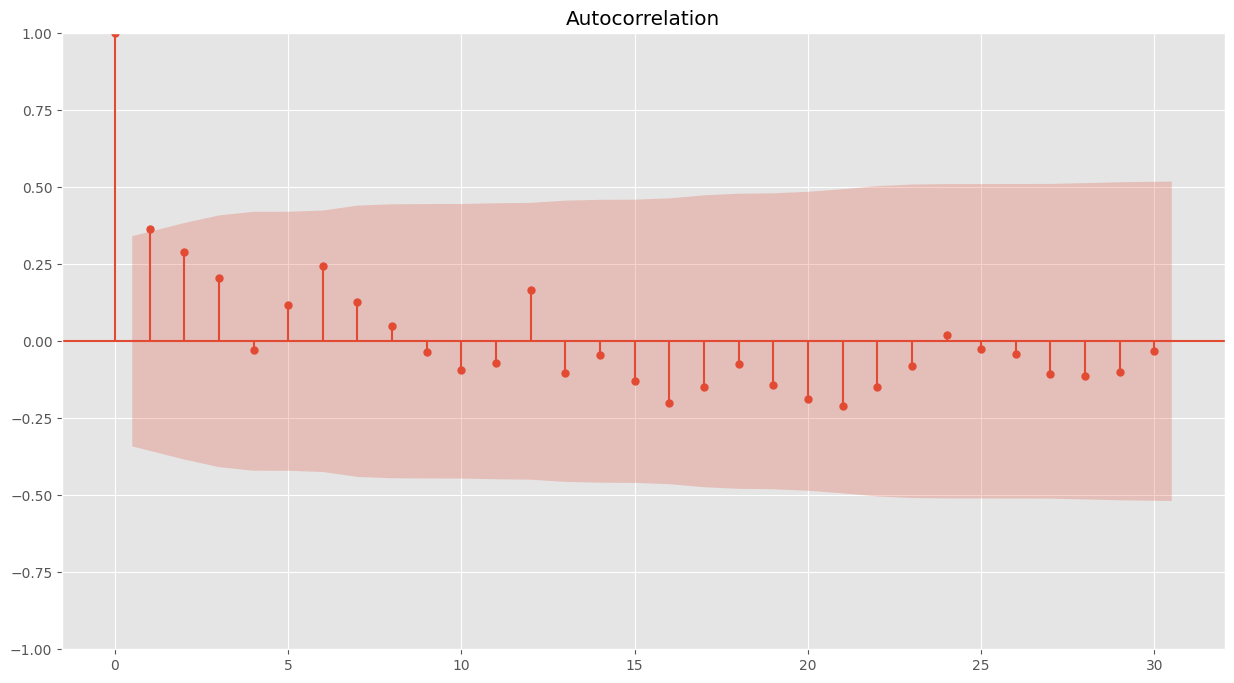

In [285]:
plot_acf(data.resample(pd.offsets.MonthEnd()).mean()['0'], lags = 30); # автокорреляция месячные данные

Агрегированные по месяцам данные имеют короткую временную зависимость, на начальных лагах видим статистически значимую автокорреляцию, т.е. значения соседних месяцев связаны между собой с небольшой зависимостью, далее автокорреляция быстро убывает и не выходит за зоны дов интервала. Видна слабая сезонность - через 6 шагов столбики в положительной зоне повторяются.

Сделаем декомпозицию ряда

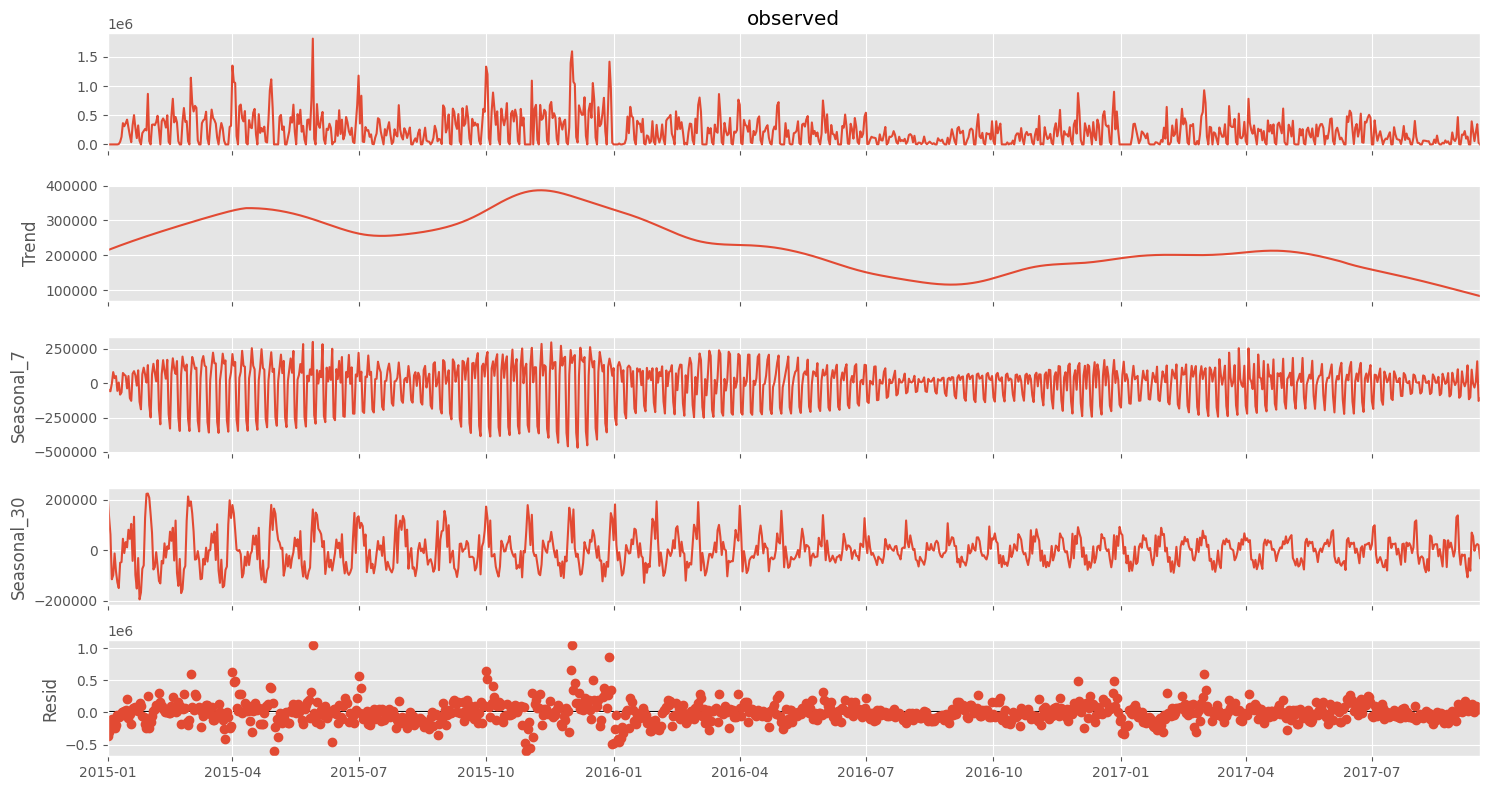

In [286]:
stl = MSTL(
    data['0'],
    periods=[7, 30],

    stl_kwargs={
        "trend": 201,
        # "seasonal_deg": 0,
        # "robust": True
    }
)
res = stl.fit()
res.plot();

# можно добавить период 365, но в целом остатки и так достаточно неплохие, похожи на белый шум, если добавлять лаг 365, то долго будт работать

1) Тренд: Сначала рост, затем падение, далее снова рост и небольшое снижение в конце. Есть долгосрочные изменения в данных - пользователи снимают все меньше наличных - онлайн платежи вошли в плотный оборот, наличные деньги все меньше пользуются спросом.

2) Сезонность 7 дней: Наблюдаются периодические колебания с недельной сезонностью, студенты снимают деньги на ежедневные нужны. Амплитуда колебаний меняется, возможно, из-за взаимодействия с трендом. Амплитуда снижена в периоды с июля по октябрь - сессия заканчивается и студенты уезжают по домам в родные города, занятий в университете нет - спрос на деньги минимален.

3) Сезонность 30 дней: Еще одна переодичность связана с месячными циклами, например выдачей стипендий, зарплат преподавателей и других ежемесячных платежей, таких как аренда жилья – возможны крупные платежи в начале/конце месяца. Если присмотреться, то амплитуда так же снижена с июля по октябрь.


Посмотрим на остатки после декомпозиции ряда:

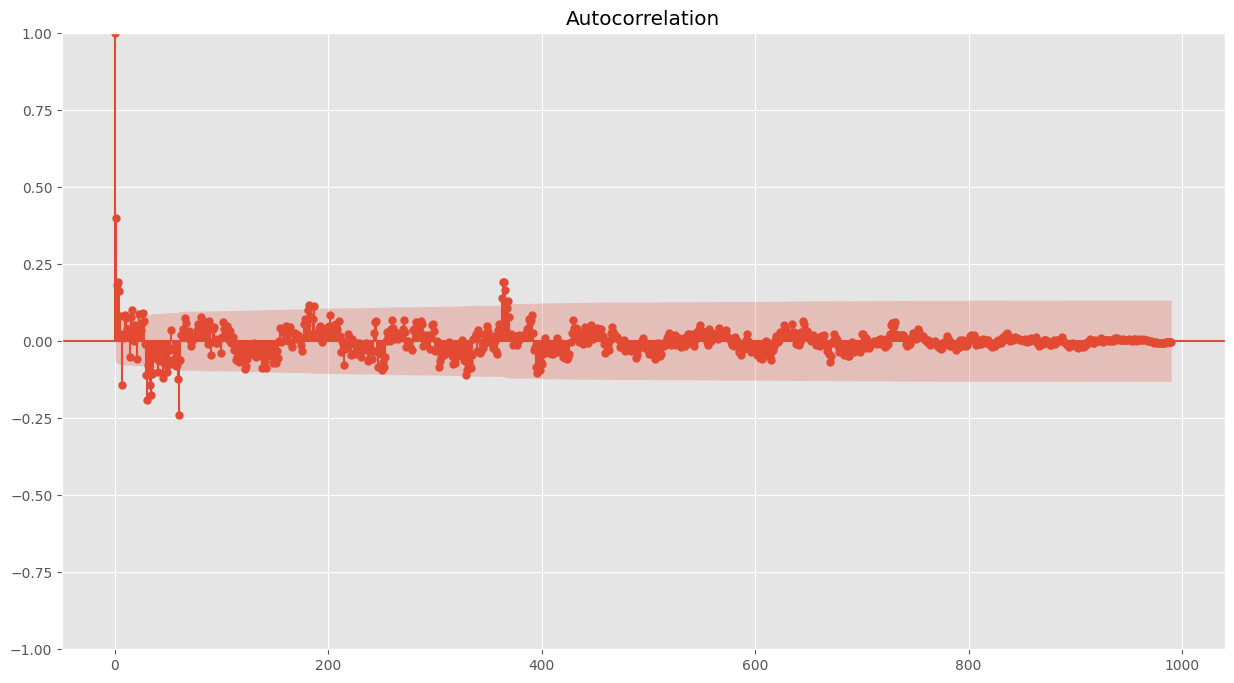

In [287]:
 plot_acf(res.resid, lags=990);

На малых лагах (до примерно 100 точек) есть небольшие выбросы, но затем значения быстро входят в доверительный интервал. Это означает, что остатки приближены к белому шуму — нет сильной зависимости между соседними наблюдениями. Такой результат подтверждает, что тренд и сезонность были успешно удалены. Заметен небольшой выброс на лаге примерно 365 - есть цикличность годовая, она осталась в ряде после декомпозиции, что в целом логично, ее мы и не убирали:)

Там разложение было бы достаточно долгим.

## 3) Выбор признаков (1.75 балла)

#### 3.1) Стандартные признаки (1.25 балла)
Исходя из свойств ряда, а также дополнительной информации из файла `description.csv` определите список фич, которые вы будете использовать для прогнозирования.

Мы подробно обсуждали генерацию признаков на семинаре. У вас есть следующие опции:

1) Использование времени (индикаторы, сезонность через тригонометрию, структурные сдвиги, календари праздников и т.п.)
2) Лаги таргета и различные функции от них
3) Статистики, рассчитанные по окну

Обоснуйте выбор каждой переменной.

Требования:
* Не менее 10 признаков
* Обоснование признаков должно согласовываться с характеристиками ряда из пункта 2 и здравым смыслом.
* За каждую логическую ошибку в обосновании или отсутствие обоснования снимается 0.5 балла (макс. 1.5 балла, в минус не уходим)

#### 3.2) Внешние переменные (0.5 балла)
Придумайте какую-нибудь интересную переменную и найдите данные для неё в интернете, исходя из местоположения банкомата и его описания. Обоснуйте её значимость.

Бонус до 0.5 балла: На усмотрение ассистента, если было собрано несколько достойных переменных или было сделано что-то неординарное с вау-эффектом.

In [288]:
desc = pd.read_csv('https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/refs/heads/master/2025-spring/homeworks/hw1/description.csv')
desc

,Unnamed: 0,ATM_ID,ADDRESS,ADDR_ADDON,LATITUDE,LONGITUDE
0,452,1,"ул Вавилова, 57",Дарвиновский музей,55.690624,37.561489
1,741,0,"ул Моховая, 9",Факультет журналистики МГУ им.М.В.Ломоносова,55.754566,37.610783
2,1563,2,"пл Манежная, 1, 2","ТК ""Охотный ряд""",55.755772,37.614609


In [289]:
import holidays
ru_holidays = holidays.RU()

data['y_L7'] = data['0'].shift(7)
data['y_L30'] = data['0'].shift(30)
data['dow'] = data.index.day_name()
data['is_weekend'] = data.index.weekday>=5
data['tommorow_is_weekend'] = data['is_weekend'].shift(-1).astype('bool')
data['tommorow_is_monday'] = (data['dow']=='Monday').shift(-1).astype('bool')
data['is_holiday'] = data.index.to_series().apply(lambda x: x in ru_holidays)
data['month_name'] = data.index.month_name()

t = np.arange(data.shape[0])
data['sin_7'] = np.sin(t*np.pi*2/30)
data['cos_7'] = np.cos(t*np.pi*2/30)
data = data.dropna()
data.head(3)

,1,0,2,y_L7,y_L30,dow,is_weekend,tommorow_is_weekend,tommorow_is_monday,is_holiday,month_name,sin_7,cos_7
Date,,,,,,,,,,,,,
2015-01-31,471100.0,56700.0,1091100.0,62800.0,0.0,Saturday,True,True,False,False,January,-1.133108e-15,1.000000
2015-02-01,161000.0,0.0,1257000.0,0.0,0.0,Sunday,True,False,True,False,February,2.079117e-01,0.978148
2015-02-02,295300.0,337600.0,834100.0,193500.0,0.0,Monday,False,False,False,False,February,4.067366e-01,0.913545


1) y_L7 - cоздаёт лаговую переменную, сдвигая ряд на 7 дней назад.
Это помогает учесть недельную сезонность.

2) y_L30 - Аналогично, создаёт лаговую переменную, сдвигая ряд на 30 дней назад. Учитываем месячную сезонность.

3) dow - Полезно для моделирования недельных паттернов, так как спрос на наличные зависит от дня недели.

4) is_weekend - Бинарный признак, спрос на банкоматы может быть выше или ниже в выходные.

5) tommorow_is_weekend - Бинарный признак, заглядывающая вперед переменная, полезен, так как люди снимают меньше денег в выходные.

6) tommorow_is_monday -  Бинарный признак, в понедельник студенты возвращаются в университет, и спрос на наличные может меняться.

7) is_holiday - Бинарный признак, проверяет, является ли день праздничным.

8) month_name - Полезно для учёта годовой сезонности (например, декабрь – повышенный спрос перед Новым годом, июль – низкая активность из-за каникул).

9) sin_7 - Кодирует 30-дневную сезонность с помощью синусоидной функции.

10) cos_7 - Аналогично, добавляется косинусоидальная функция для 30-дневной сезонности.

## 4) Одношаговое прогнозирование (2.2 балла)

#### 4.1) Предобработка (0.5 балла)

Сформируйте таблицу для одношагового прогнозирования.

* Разбейте полученные данные на трейн, валидацию и тест. Размеры выборок: 0.6, 0.2 и 0.2 соответственно. Не используйте шаффл, разбивайте упорядоченную выборку.
* Если необходимо, отнормируйте данные. Не забудьте, что валидацию или тест не надо нормировать.
* Если необходимо, закодируйте категориальные фичи любым валидным методом.

Во временных рядах очень важно избегать утечек в данных (data leak). Их легко допустить при неаккуратной генерации признаков. Например, если вы для прогноза $y_t$ будете исплользовать фичу разности $y_t - y_{t-1}$. Будьте осторожны и внимательны.


In [290]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [291]:
y = data['0']
X = data.drop(columns=['1', '2','0'])
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = False, test_size = 0.4)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, shuffle = False, test_size = 0.5)

In [292]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 2015-01-31 to 2016-08-28
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   y_L7                 576 non-null    float64
 1   y_L30                576 non-null    float64
 2   dow                  576 non-null    object 
 3   is_weekend           576 non-null    bool   
 4   tommorow_is_weekend  576 non-null    bool   
 5   tommorow_is_monday   576 non-null    bool   
 6   is_holiday           576 non-null    bool   
 7   month_name           576 non-null    object 
 8   sin_7                576 non-null    float64
 9   cos_7                576 non-null    float64
dtypes: bool(4), float64(4), object(2)
memory usage: 33.8+ KB


In [293]:
num_cols = X.select_dtypes(include = ['float','bool']).columns
cat_cols = ['dow', 'month_name']
pipe_cat = Pipeline([('ohe', OneHotEncoder())])
preprocessor = ColumnTransformer([('cat', pipe_cat, cat_cols), ('num', 'passthrough', num_cols)])

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [294]:
ohe_feature_names = preprocessor.get_feature_names_out()
ohe_feature_names

array(['cat__dow_Friday', 'cat__dow_Monday', 'cat__dow_Saturday',
       'cat__dow_Sunday', 'cat__dow_Thursday', 'cat__dow_Tuesday',
       'cat__dow_Wednesday', 'cat__month_name_April',
       'cat__month_name_August', 'cat__month_name_December',
       'cat__month_name_February', 'cat__month_name_January',
       'cat__month_name_July', 'cat__month_name_June',
       'cat__month_name_March', 'cat__month_name_May',
       'cat__month_name_November', 'cat__month_name_October',
       'cat__month_name_September', 'num__y_L7', 'num__y_L30',
       'num__is_weekend', 'num__tommorow_is_weekend',
       'num__tommorow_is_monday', 'num__is_holiday', 'num__sin_7',
       'num__cos_7'], dtype=object)

#### 4.2) Регрессия (1 балл)

Выберите вашу любимую модель и решите задачу одношагового прогнозирования.

* Подберите гиперпараметры на валидационной выборке.
* После подбора гиперпараметров обучите ваш регрессор на трейне + валидации.

 Кросс-валидацию мы ещё пройти не успели, поэтому метрику будем считать только по тестовой выборке. Подсчитайте качество одношаговых прогнозов. В качестве метрики используйте WAPE.

$$WAPE=\frac{\sum_{t=1}^n\left|A_t-F_t\right|}{\sum_{t=1}^n\left|A_t\right|}, \quad A_t - Actual, F_t - Forecast$$

При подсчёте метрик вам нужно построить прогнозы в номированных величинах, использовать параметры тренировочноый (или тренировочной + валидационной) выборки для обратной нормировки, а потом подсчитать метрики в исходных величинах. Все метрики вычисляются в исходных величинах!

In [295]:
# !pip install optuna
# !pip install catboost

In [296]:
import catboost as cb
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'loss_function': 'RMSE',
        'eval_metric': 'MAE',
        'random_state': 42,
        'verbose': 0,
    }

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    y_pred = model.predict(X_val)
    return mean_absolute_error(y_val, y_pred)

In [297]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-04 20:05:25,319] A new study created in memory with name: no-name-42ffb78d-3324-406e-bd53-5aa594467523
[I 2025-02-04 20:05:26,657] Trial 0 finished with value: 105857.62591312642 and parameters: {'iterations': 630, 'learning_rate': 0.027115938987758256, 'depth': 6}. Best is trial 0 with value: 105857.62591312642.
[I 2025-02-04 20:05:27,436] Trial 1 finished with value: 108055.02705154603 and parameters: {'iterations': 884, 'learning_rate': 0.22601189322315568, 'depth': 8}. Best is trial 0 with value: 105857.62591312642.
[I 2025-02-04 20:05:30,520] Trial 2 finished with value: 109476.47849567783 and parameters: {'iterations': 179, 'learning_rate': 0.027425005544049065, 'depth': 10}. Best is trial 0 with value: 105857.62591312642.
[I 2025-02-04 20:05:33,386] Trial 3 finished with value: 108709.10339869709 and parameters: {'iterations': 334, 'learning_rate': 0.05769901852728029, 'depth': 9}. Best is trial 0 with value: 105857.62591312642.
[I 2025-02-04 20:05:35,332] Trial 4 fin

Best trial:
  Value: 103296.92851358178
  Params: 
    iterations: 551
    learning_rate: 0.12887611039967511
    depth: 5


In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False, test_size = 0.4)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

best_params = trial.params
final_model = CatBoostRegressor(**best_params, verbose=0)
final_model.fit(X_train, y_train)
preds_cb_4_2 = final_model.predict(X_test)

def wape(actual, forecast):
    return np.sum(np.abs(actual - forecast)) / np.sum(np.abs(actual))
wape_4_2 = wape(y_test, preds_cb_4_2)
print("WAPE:", wape_4_2)

WAPE: 0.8422844090141544


#### 4.3) Бенчмарк (0.5 балла)

Постройте прогноз с помощью сезонной наивной модели.
Она возвращает в качестве прогноза последнее доступное значение за аналогичный сезон. Например, если мы предполагаем недельную сезонность на дневных данных и строим прогноз на понедельник, в качестве значения следует взять последний доступный понедельник из трейна.

Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже.

In [299]:
large_array = np.array(y_test)
small_array = np.array(y_train[-7:])

naive_preds_4_3 = np.tile(small_array, (len(large_array) // len(small_array) + 1))[:len(large_array)]
wape_naive_4_3 = wape(y_test, naive_preds_4_3)
print("WAPE:", wape_naive_4_3)

WAPE: 0.7918063737837446


Качество действительно не хуже, чем у катбуста выше.

#### 4.4) Визуализация (0.2 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели.

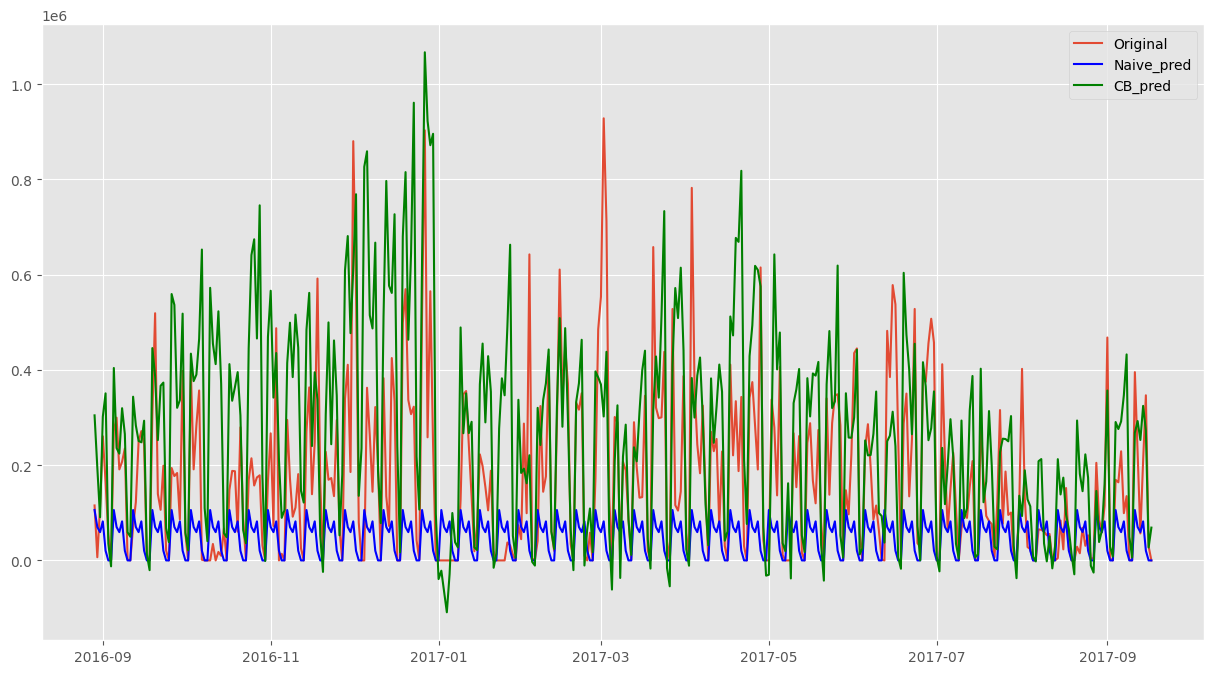

In [300]:
plt.plot(y_test, label = 'Original')
plt.plot(pd.DataFrame(index = y_test.index,data = naive_preds_4_3), color = 'Blue', label = 'Naive_pred')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_cb_4_2), color = 'green', label = 'CB_pred')
plt.legend();

Наивный прогноз (синяя линия) слишком сглаженный – он не учитывает высокую изменчивость данных и может быть полезен только как бенчмарк.

Катбуст (зеленая линия) явно лучше – она отражает волатильность, но есть ошибки в предсказании экстремальных значений (слишком резкие всплески) - из-за этог wape больше, чем у наивного прогноза.

## 5) Многошаговое прогнозирование (4.8 балла)


В этой части вам необходимо реализовать ряд стратегий многошагового прогнозирования. Описание всех необходимых стратегий есть в [конспекте](https://github.com/Pyatachokk/hse_ts_course/blob/master/2025-spring/lectures/ts_notes/ts_notes.pdf). Пользоваться готовыми библиотеками запрещается, стратегии должны быть реализованы вручную.

Горизонт прогнозирования: 4 недели.

#### 5.1) Препроцессинг (0 баллов)

Перераспределите размеры выборок трейна, валидации и теста. Валидация и тест должны быть по 4 недели, а всё остальное -- в трейн.

В каждой из стратегий предполагается, что вы сначала подберёте гиперпараметры на валидации, а финальную модель обучите на трейне + валидации для прогноза на тест.

Сделайте любой дополнительный препроцессинг, если он вам необходим.

In [301]:
def new_features(mass, lags = [1, 7, 14, 28]):
  for lag in lags:
    mass[f'lag_y-{lag}'] = mass['0'].shift(lag)
  mass = mass.dropna()
  return mass

new_df = new_features(pd.DataFrame(data['0']), lags = [1, 7, 14, 28])
y = new_df['0']
X = new_df.drop(columns = ['0'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 4*7*2/X.shape[0], shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)

#### 5.2) Рекурсивная стратегия (1.75 балла)

 Реализуйте рекурсивное прогнозирование на выбранном горизонте с помощью вашей любимой табличной модели.

 Если в пункте 3.2 вы добавляли внешнюю переменную, вам придётся её прогнозировать для рекурсивной стратегии. Либо используйте какую-нибудь простую модел (желательно), либо просто уберите этот признак из датасета.

In [302]:
def recursion_func(model, X, y, steps=28):
    predictions = []

    for _ in range(steps):
        pred = model.predict(X.iloc[-1])
        predictions.append(pred)
        y = pd.concat([y, pd.DataFrame({'0': [pred]}, index=[X.index[-1] + pd.Timedelta(days=1)])])
        X = pd.concat([X, new_features(y[['0']]).iloc[-1:]]).drop(columns=['0'])
    return predictions

In [303]:
best_score = float('inf')
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7]
}

for n_est in params['n_estimators']:
    for lr in params['learning_rate']:
        for depth in params['max_depth']:

            model = CatBoostRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, verbose=0)
            model.fit(X_train, y_train)

            preds = recursion_func(model, X_train.copy(), y_train.copy())
            rmse = mean_squared_error(y_val, preds)**0.5
            print(f"RMSE (n_est={n_est}, lr={lr}, depth={depth}): {rmse}")


            if rmse < best_score:
                best_score = rmse
                best_model = model

print("Лучший RMSE:", best_score)

RMSE (n_est=50, lr=0.01, depth=3): 176902.90492188238
RMSE (n_est=50, lr=0.01, depth=5): 177893.99517071465
RMSE (n_est=50, lr=0.01, depth=7): 178177.2995676017
RMSE (n_est=50, lr=0.1, depth=3): 134832.59378710308
RMSE (n_est=50, lr=0.1, depth=5): 163767.88073503648
RMSE (n_est=50, lr=0.1, depth=7): 136294.89678807947
RMSE (n_est=50, lr=0.3, depth=3): 142780.28422906977
RMSE (n_est=50, lr=0.3, depth=5): 146914.94720364525
RMSE (n_est=50, lr=0.3, depth=7): 146144.46424265156
RMSE (n_est=100, lr=0.01, depth=3): 165130.40692395988
RMSE (n_est=100, lr=0.01, depth=5): 166839.15220237375
RMSE (n_est=100, lr=0.01, depth=7): 166548.49786542513
RMSE (n_est=100, lr=0.1, depth=3): 125776.98897926314
RMSE (n_est=100, lr=0.1, depth=5): 163631.8873348944
RMSE (n_est=100, lr=0.1, depth=7): 140618.90626027057
RMSE (n_est=100, lr=0.3, depth=3): 120731.25754409643
RMSE (n_est=100, lr=0.3, depth=5): 152383.38800812847
RMSE (n_est=100, lr=0.3, depth=7): 183956.37235766056
RMSE (n_est=200, lr=0.01, depth=3

Обучаем финальную версию


In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 4*7/X.shape[0], shuffle = False)
best_model.fit(X_train, y_train)
preds_5_2 = recursion_func(best_model, X_train, y_train)
wape_5_2 = wape(y_test, preds_5_2)
print("WAPE:", wape_5_2)

WAPE: 0.9169633084247371


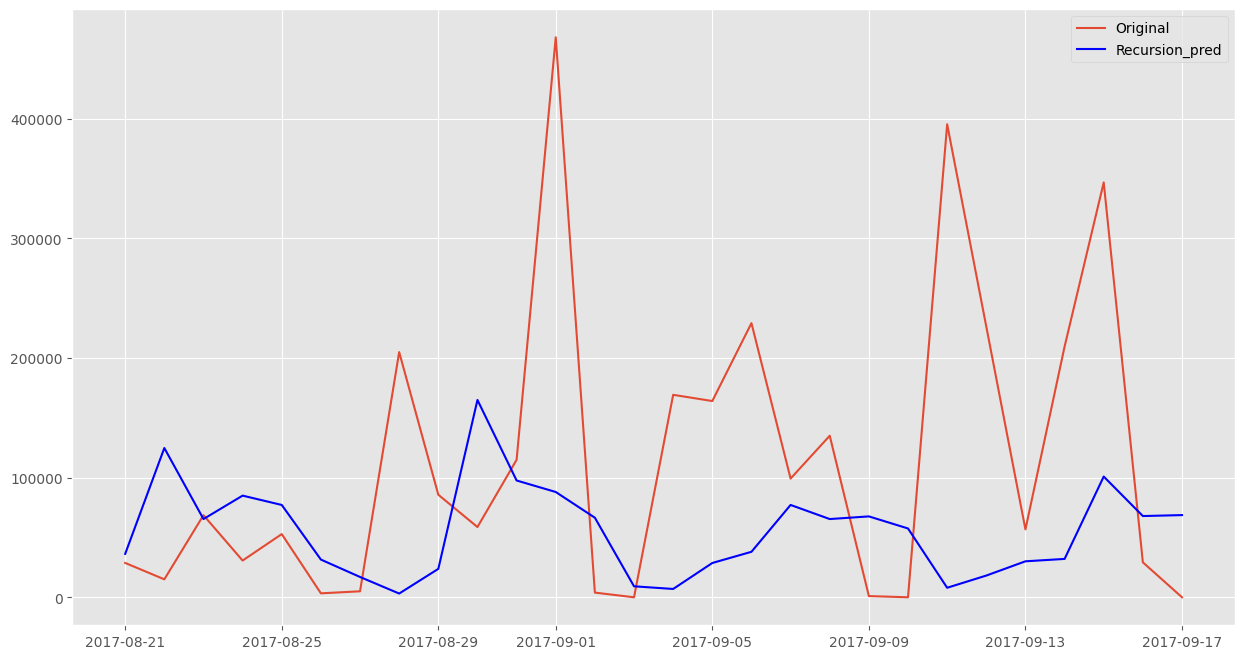

In [342]:
plt.plot(y_test, label = 'Original')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_2), color = 'blue', label = 'Recursion_pred')
plt.legend();

Рекурсивный прогноз (синяя линия) сглажен и менее волатилен, чем фактические значения. Это ожидаемо, так как каждый последующий прогноз зависит от предыдущего предсказания,что приводит к потере резких изменений - такие модели не улавливают внезапные всплески, так как ошибка на каждом шаге накапливается.


#### 5.3) Прямая стратегия (1.25 балла)

Реализуйте прямое прогнозирование на ваш горизонт с помощью вашей любимой табличной модели.

In [306]:
new_df = new_features(pd.DataFrame(data['0']), lags = [1, 7, 14, 28])
y = new_df['0']
X = new_df.drop(columns = ['0'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 4*7*2/X.shape[0], shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)

In [307]:
def direct_forecast(model_list, X):
    predictions = []
    X_last = X.iloc[-1:]
    for model in model_list:
        y_pred = model.predict(X_last)
        predictions.append(y_pred[0])
    return predictions

In [308]:
best_score = float('inf')
params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.3],
    'max_depth': [3, 5]
}

for n_est in params['n_estimators']:
    for lr in params['learning_rate']:
        for depth in params['max_depth']:

            model_list = []

            for step in range(28):
                y_target = y_train.shift(-step).dropna()
                X_target = X_train.iloc[:len(y_target)]

                model = CatBoostRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, verbose=0)
                model.fit(X_target, y_target)
                model_list.append(model)

            preds = direct_forecast(model_list, X_train)
            rmse = mean_squared_error(y_val, preds)**0.5
            print(f"RMSE (n_est={n_est}, lr={lr}, depth={depth}): {rmse}")

            if rmse < best_score:
                best_score = rmse
                best_model_list = model_list

print("Лучший RMSE:", best_score)

RMSE (n_est=100, lr=0.1, depth=3): 192488.87548505352
RMSE (n_est=100, lr=0.1, depth=5): 192826.16046379897
RMSE (n_est=100, lr=0.3, depth=3): 192674.25609314977
RMSE (n_est=100, lr=0.3, depth=5): 209268.74642827365
RMSE (n_est=200, lr=0.1, depth=3): 193131.00360359284
RMSE (n_est=200, lr=0.1, depth=5): 199018.46641864782
RMSE (n_est=200, lr=0.3, depth=3): 193417.6138884278
RMSE (n_est=200, lr=0.3, depth=5): 215899.2859708139
Лучший RMSE: 192488.87548505352


In [309]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 4*7/X.shape[0], shuffle = False)
preds_5_3 = direct_forecast(best_model_list, X_train)
wape_5_3 = wape(y_test, preds_5_3)
print("WAPE:", wape_5_3)

WAPE: 1.325632218186366


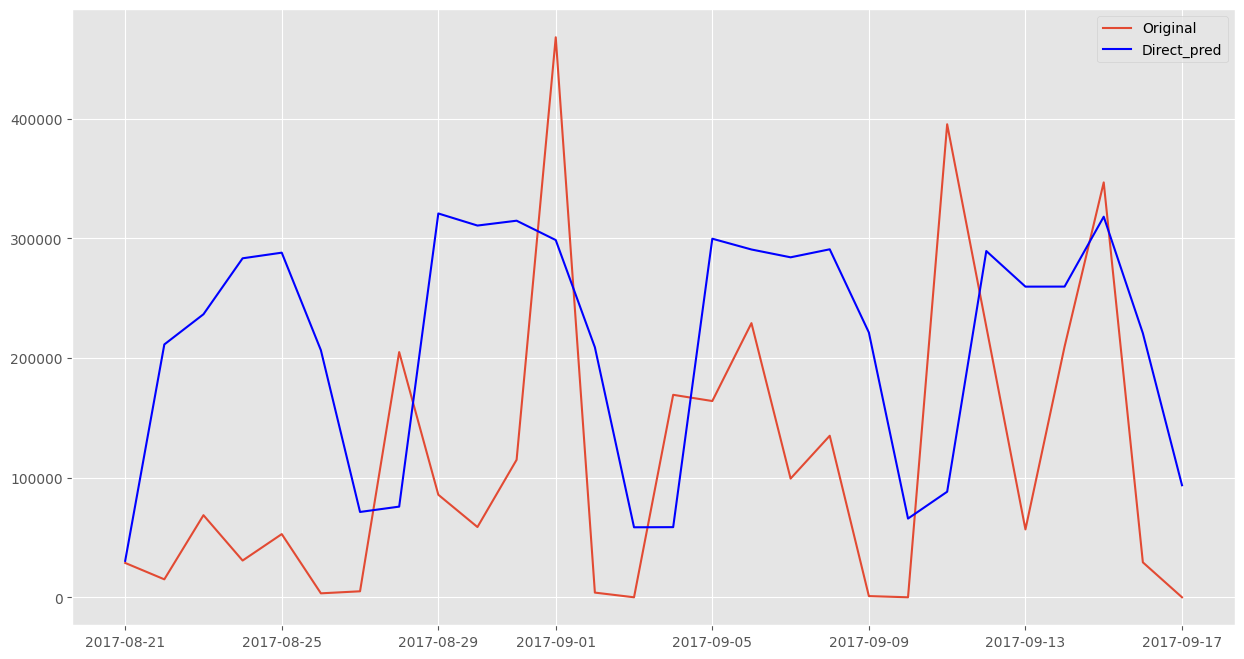

In [343]:
plt.plot(y_test, label = 'Original')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_3), color = 'blue', label = 'Direct_pred')
plt.legend();

Прогноз (синяя линия) переоценивает значения на большинстве точек.
Он смещён вверх относительно фактических данных. Откровенно говоря, получилось крайне скверно. Возможность что-то обучилось неправильно.

#### 5.4) Стратегия DirRec (1 балл)

Реализуйте смешанное прогнозирование на ваш горизонт с помощью вашей любимой табличной модели.

In [311]:
new_df = new_features(pd.DataFrame(data['0']), lags = [1, 7, 14, 28])
y = new_df['0']
X = new_df.drop(columns = ['0'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 4*7*2/X.shape[0], shuffle = False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)

In [312]:
def dirrec_forecast(model_list, X):
    predictions = []
    X_last = X.iloc[-1:].copy()

    for step, model in enumerate(model_list):
        y_pred = model.predict(X_last)

        X_last.loc[X_last.index, f'y_pred_y+{step}'] = y_pred
        predictions.append(y_pred)

    return predictions

Подбор гиперпараметров порядка 50 секунд((

In [313]:
best_score = float('inf')
params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.2, 0.3],
    'max_depth': [3, 5]
}

for n_est in params['n_estimators']:
    for lr in params['learning_rate']:
        for depth in params['max_depth']:
            model_list = []
            X_target = X_train.copy()

            for i in range(28):
                y_target = y_train.shift(-i).dropna()
                X_step = X_target.iloc[:len(y_target)].copy()

                model = CatBoostRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, verbose=0)
                model.fit(X_step, y_target)
                model_list.append(model)

                y_pred_insample = model.predict(X_step)
                X_target.loc[X_target.index[:len(y_target)], f'y_pred_y+{i}'] = y_pred_insample

            preds = dirrec_forecast(model_list, X_val)

            rmse = mean_squared_error(y_val[:len(preds)], preds) ** 0.5
            print(f"RMSE (n_est={n_est}, lr={lr}, depth={depth}): {rmse}")

            if rmse < best_score:
                best_score = rmse
                best_model_list = model_list

print("Лучший RMSE:", best_score)

RMSE (n_est=50, lr=0.2, depth=3): 211631.46517137057
RMSE (n_est=50, lr=0.2, depth=5): 158588.90748498446
RMSE (n_est=50, lr=0.3, depth=3): 148923.67445265772
RMSE (n_est=50, lr=0.3, depth=5): 181407.2674745001
RMSE (n_est=100, lr=0.2, depth=3): 203053.1665520788
RMSE (n_est=100, lr=0.2, depth=5): 161890.2333178792
RMSE (n_est=100, lr=0.3, depth=3): 190543.40313988898
RMSE (n_est=100, lr=0.3, depth=5): 298116.28596622497
Лучший RMSE: 148923.67445265772


In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 4*7/X.shape[0], shuffle = False)
preds_5_4 = dirrec_forecast(best_model_list, X_train)
wape_5_4 = wape(y_test, preds_5_4[0])
print("WAPE:", wape_5_4)

WAPE: 0.8481078370344453


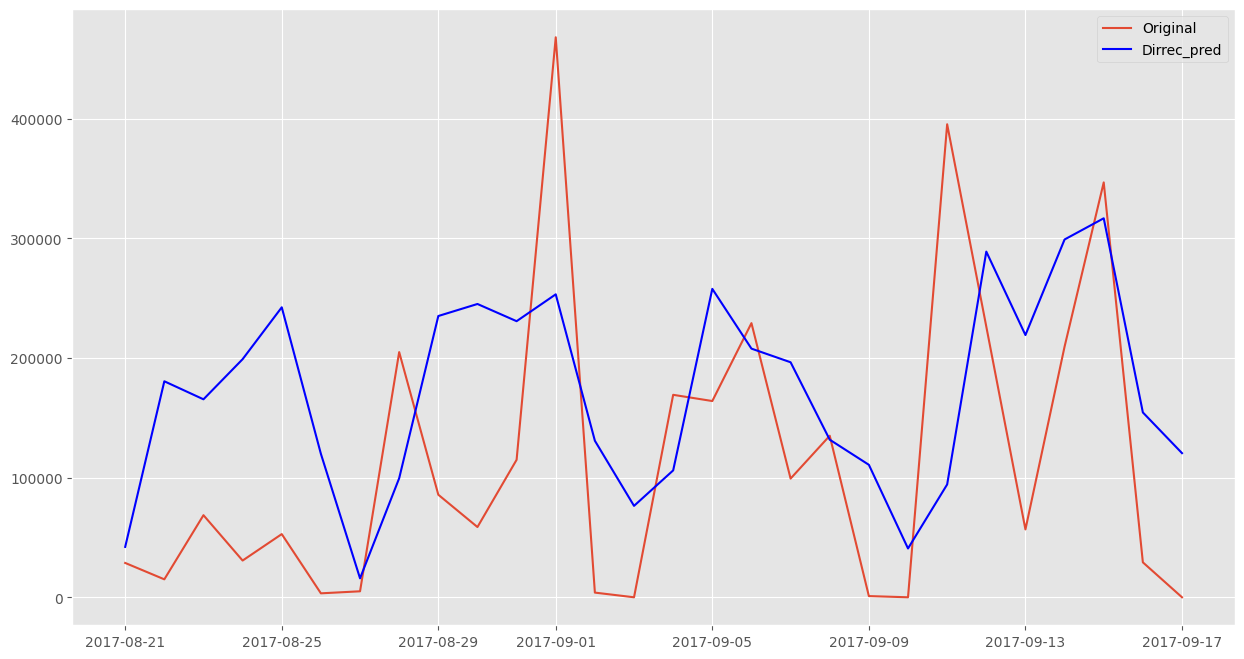

In [344]:
plt.plot(y_test, label = 'Original')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_4), color = 'blue', label = 'Dirrec_pred')
plt.legend();

Гибридная стратегия дала лучше прогноз, чем рекурсивная и прямая, но она все так же сильно сглаживает резкие пики и падения. Модель нормально улавливает общий тренд, но запаздывает в экстремальных точках.

#### 5.5) Ваша стратегия (Бонус 1 балл)

Найдите и реализуйте какую-нибудь стратегию. Можете взять не рассмотренные из конспекта, найти в интернете или предложить свою собственную. Поясните принцип её работы.

Наивная стратегия с усреднением значений:

In [316]:
new_df = new_features(pd.DataFrame(data['0']), lags = [7, 14, 21, 28, 42])
y = new_df['0']
X = new_df.drop(columns = ['0'])

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 4*7/X.shape[0], shuffle = False)
naive_preds_5_5 = X_test.mean(axis = 1)
wape_naive_5_5= wape(y_test, naive_preds_5_5)
print("WAPE:", wape_naive_5_5)

WAPE: 0.6575078874207353


Наивная стратегия прогнозирования: прогноз для каждого дня рассчитывается как среднее значение прошлых лагов (7, 14, 21, 28, 35, 42 дней). Такой подход учитывает недельную и месячную сезонность, но сглаживает резкие всплески и падения. Используется как базовый ориентир для оценки качества сложных моделей.

Далее попробуем вторую модель - оцениваем коэффиценты регрессии, обученной на тренировочных данных, используем лаги (7, 14, 21, 28, 42 дней) как регрессоры. Все признаки являются значимыми на 5% уровне. Значение F-statistic = 87.90 достаточно высокое, что говорит о том, что модель статистически значима. R2 = 0.33 - описываем разброс данных слабовато.

In [318]:
import statsmodels.api as sm
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const)
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     87.90
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           4.43e-75
Time:                        20:08:20   Log-Likelihood:                -12149.
No. Observations:                 891   AIC:                         2.431e+04
Df Residuals:                     885   BIC:                         2.434e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.815e+04   1.12e+04      4.315      0.0

In [319]:
X_test_const = sm.add_constant(X_test, has_constant='add')
preds_5_5= results.predict(X_test_const)
wape_5_5= wape(y_test, preds_5_5)

print("WAPE:", wape_5_5)

WAPE: 0.7156777185029586


Изобразим на графике исходное и предсказанные значения ряда.

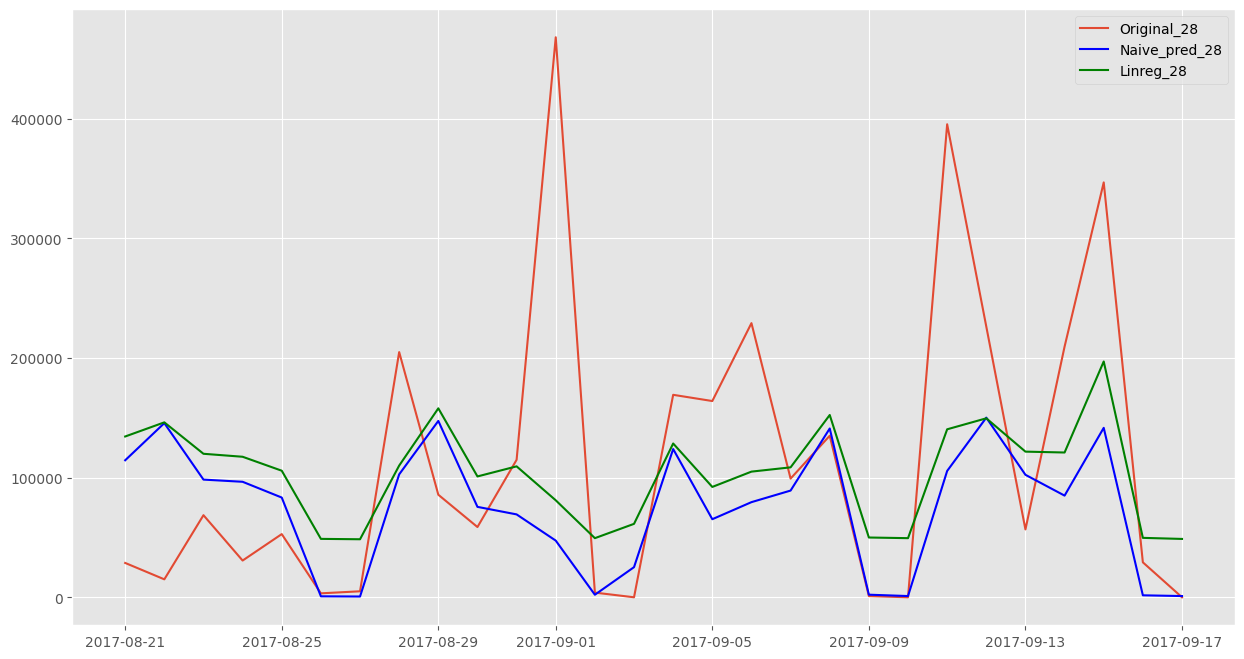

In [320]:
plt.plot(y_test, label = 'Original_28')
plt.plot(pd.DataFrame(index = y_test.index,data = naive_preds_5_5), color = 'Blue', label = 'Naive_pred_28')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_5), color = 'green', label = 'Linreg_28')
plt.legend();

In [345]:
pd.DataFrame({
    "Model": ["WAPE_5_5", "Naive_WAPE_5_5"],
    "WAPE Value": [wape_5_5, wape_naive_5_5]
})

# ошибка по самодельным моделям

,Model,WAPE Value
0,WAPE_5_5,0.715678
1,Naive_WAPE_5_5,0.657508


Синяя линия (наивный прогноз) более сглажена, хуже предсказывает пики, но неплохо отражает общий тренд. Зелёная линия (линейная регрессия) ближе к фактическим данным, лучше улавливает сезонные колебания, но всё ещё сглаживает резкие скачки. Однако, она более приближена к оригинальным данным, особенно при колебаниях. Синяя слишком усредняет прогноз.

Построены достаточно простые стратегии, однако справляются они не хуже более продвинутых версий, если судить по метрике, по графику все тоже весьма прилично.

#### 5.6) Бенчмарк (0.5 балла)

Постройте прогноз сезонной наивной модели. Для многошаговой модели она устроена аналогично одношаговой. Для каждого прогнозного значения мы берём последнее доступное значение за аналогичный сезон.



In [321]:
new_df = new_features(pd.DataFrame(data['0']), lags = [1, 7, 14, 28])
y = new_df['0']
X = new_df.drop(columns = ['0'])

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 4*7/X.shape[0], shuffle = False)

large_array = np.array(y_test)
small_array = np.array(y_train[-7:])

naive_preds_5_6 = np.tile(small_array, (len(large_array) // len(small_array) + 1))[:len(large_array)]

wape_naive_5_6 = wape(y_test, naive_preds_5_6)
print("WAPE:", wape_naive_5_6)

WAPE: 0.8095773591978259


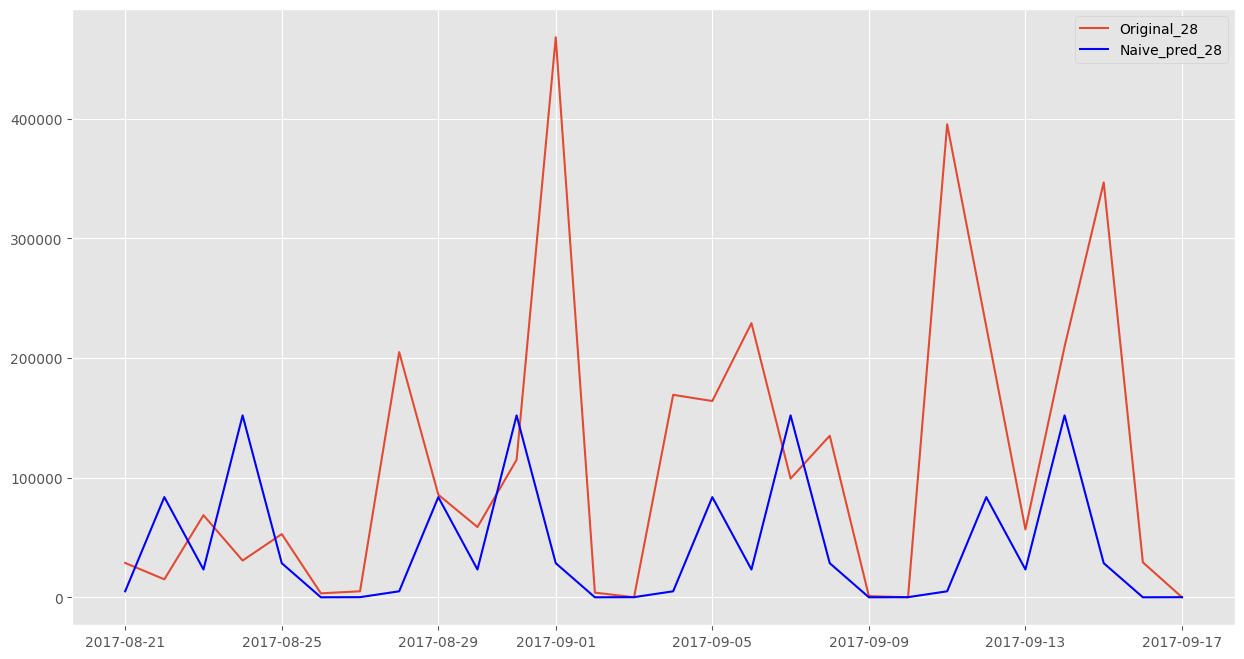

In [340]:
plt.plot(y_test, label = 'Original_28')
plt.plot(pd.DataFrame(index = y_test.index,data = naive_preds_5_6), color = 'blue', label = 'Naive_pred_28')
plt.legend();

Наивный прогноз по wape - лучший из всех рассмотренных выше стратегий.

In [350]:
pd.DataFrame({
    "Model": ["Naive"],
    "WAPE Value": [wape_naive_5_6]
})

,Model,WAPE Value
0,Naive,0.809577


#### 5.7) Результаты (0.3 балла)

Визуализируйте прогнозы стратегий, наивной модели, а также тестовые данные на одном графике. Добавьте небольшой хвост трейна + валидации (примерно горизонт x 2), так будет лучше видно.  Подсчитайте WAPE прогнозов на тестовой выборке и соберите их в одну таблицу. Какая стратегия оказалась лучше? Получилось ли побить наивную? Как вы думаете, почему?

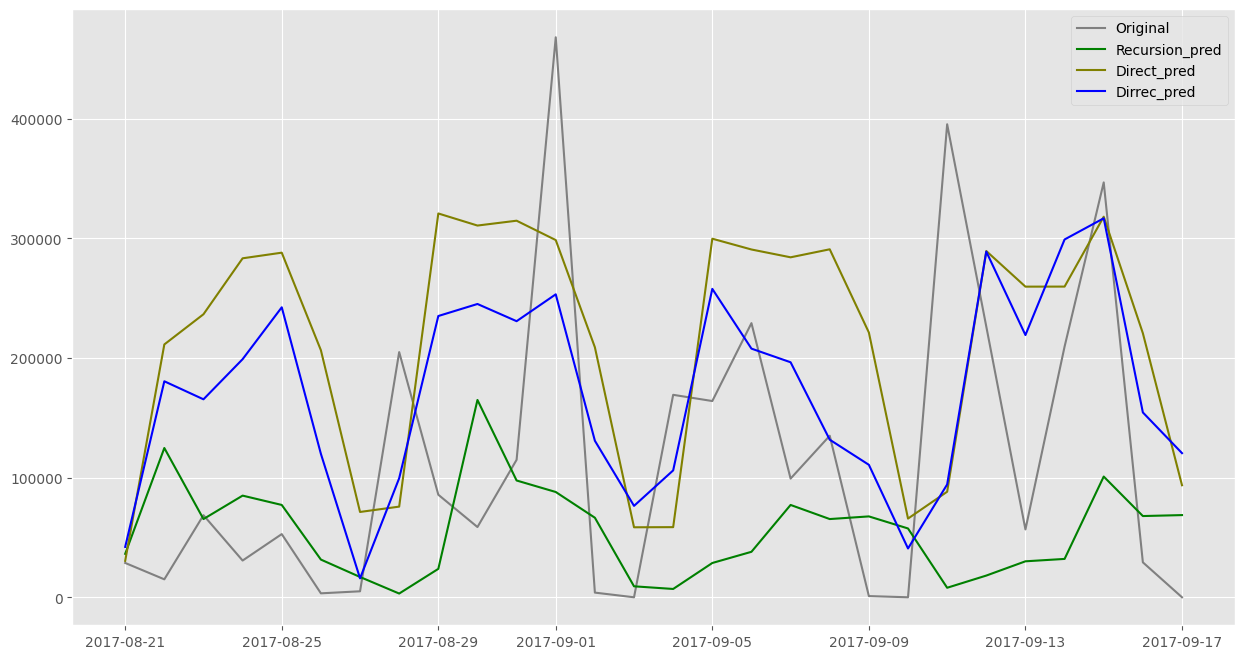

In [356]:
plt.plot(y_test, label = 'Original', color = 'gray')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_2), color = 'green', label = 'Recursion_pred')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_3), color = 'olive', label = 'Direct_pred')
plt.plot(pd.DataFrame(index = y_test.index,data = preds_5_4), color = 'blue', label = 'Dirrec_pred')
plt.legend();

In [351]:
pd.DataFrame({
    "Model": ["Recursion", "Direct", 'Dirrec', 'Naive'],
    "WAPE Value": [wape_5_2, wape_5_3, wape_5_4, wape_naive_5_6]
})

,Model,WAPE Value
0,Recursion,0.916963
1,Direct,1.325632
2,Dirrec,0.848108
3,Naive,0.809577


По метрике - наивный прогноз выигрывает, однако для всех моделей большой проблемой является предсказание экстремальных значений, наивная стратегия не стала исключением))

Лучшая метрика получилась у простеньких самодельных моделей, одна из которых - среднее по н количество лагов, а вторая - обычная линейная регрессия.

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/eKQTEKbYKD9YripL8